In [1]:
from Linguo_tools import *
import nltk
from nltk.collocations import *
from nltk.probability import FreqDist
from tqdm import tqdm
import math

In [5]:
exp = Experimenter()
noise_order= 2
labeled_gram,labeled_ws = exp.load_corpora_from_file("Data/hundo_gram","Data/euro.hundo2_2-gramsWS")
datasplit = int(math.floor(0.8*len(labeled_gram)))
training_gram = [sent for sent,label in labeled_gram[:datasplit]]
testing_gram = [sent for sent,label in labeled_gram[datasplit:]]

training_ws = [sent for sent,label in labeled_ws[:datasplit]]
testing_ws = [sent for sent,label in labeled_ws[datasplit:]]


In [6]:
import math
from nltk import ConditionalFreqDist
import matplotlib.pyplot as plt
class Lau_classif: 
    def __init__ (self,ngram_order):
        self.ngram_order = ngram_order
        
    def train_single_LM (self,sentences,order):
        pad = self.ngram_order -1
        model = ConditionalFreqDist()
        print("Training {}-gram language model".format(order))
        for sentence in tqdm(sentences):
            sentence= ["#"]*pad + sentence
            for i in range(len(sentence) - order):
                context = tuple(sentence[i:i+order-1])
                word = sentence[i+order-1]
                model[context][word]+=1
        return model
        
    def train_full_LM(self, sentences):
        self.ngram_models = []
        for n in range(self.ngram_order,1,-1):
            self.ngram_models.append(self.train_single_LM(sentences,n))
        self.unigram_fd= FreqDist()
        for sentence in sentences:
            for token in sentence: 
                self.unigram_fd[token]+=1
        self.vocab = set(self.unigram_fd.keys())
        
    def LM_logprob_sent(self, sentence):
        sent_logprob = 0
        pad = self.ngram_order-1
        sentence = self.preprocess_sentence(sentence)
        sentence = (pad* ["#"]) + sentence
        for i in range(pad,len(sentence)):
            full_context = sentence[i-pad:i]
            word = sentence[i]
            counted = False
            mod_ind = 0
            while not counted and mod_ind<len(self.ngram_models):
                context = tuple(full_context[mod_ind:])
                if word in self.ngram_models[mod_ind][context]:
                    wprob = self.ngram_models[mod_ind][context].freq(word)
                    counted=True 
                else:
                    mod_ind+=1
            if not counted:
                wprob = self.unigram_fd.freq(word)
            wlogprob = math.log(wprob)
            sent_logprob += wlogprob
            
        return sent_logprob
        
    def uni_logprob_sent(self,sentence):
        sentence = self.preprocess_sentence(sentence)
        result = 0
        for word in sentence:
            result+= math.log(self.unigram_fd[word])
        return result
    
    def SLORscore(self,sentence):
        sentlength = len(sentence)
        sentLP = self.LM_logprob_sent(sentence)
        sentUNI= self.uni_logprob_sent(sentence)
        slor = (sentLP - sentUNI)/sentlength
        return slor
    
    def preprocess_sentence(self,sentence):
        newsentence = []
        for word in sentence:
            word = word.lower()
            if word not in self.vocab:
                newsentence.append("#unk")
            else:
                newsentence.append(word)
        return newsentence
    def plot_scores(self, gram_sentences, ws_sentences, ws_ord):
        gram_scores = [self.SLORscore(sent) for sent in gram_sentences]
        ws_scores = [self.SLORscore(sent) for sent in ws_sentences]
        n_bins = 50

        plt.hist(gram_scores, bins=n_bins, alpha=0.5, label='Word Salads',facecolor="r")
        plt.hist(ws_scores, bins=n_bins, alpha=0.5, label='Sentences',facecolor="b")
        plt.legend(loc='upper left')
        plt.axvline(x=self.threshold,color="g",alpha=1.0)
        plt.xlabel('SLOR score')
        plt.ylabel('Count')
        plt.title("SLOR scores on {WSorder}-gram WS with {order}-gram model".format(order=self.ngram_order,
                                                                           WSorder=ws_ord))
        #plt.title('Sequence lengths for trigram word salads and corpus sentences')

        plt.grid(True)
        plt.show()
    
    def train_classifier(self,train_sent_gram, train_sent_ws ):
        scored_pairs = []
        num_gram = len(train_sent_gram)
        num_ws = len(train_sent_ws)
        num_total = num_gram + num_ws
        for sentence in train_sent_gram:
            scored_pairs.append((self.SLORscore(sentence),1))
        for sentence in train_sent_ws:
            scored_pairs.append((self.SLORscore(sentence),0))
        scored_pairs.sort(key = lambda t: t[0])
        cutoff_data = []
        passed_ws = 0
        passed_gram = 0
        for cutoff,label in scored_pairs:
            if label == 0:
                passed_ws +=1
            else :
                passed_gram +=1
            accuracy = (passed_ws + (num_gram - passed_gram)) / num_total
            cutoff_data.append((accuracy,cutoff))
        accuracy, threshold = max(cutoff_data,key= lambda t: t[0])
        self.threshold =threshold
        self.training_accuracy = accuracy
        return accuracy, threshold
    
    def train_classifier_sandwich(self,train_sent_gram, train_sent_ws ):
        print("Training sandwich model")
        scored_pairs = []
        num_gram = len(train_sent_gram)
        num_ws = len(train_sent_ws)
        num_total = num_gram + num_ws
        print("Scoring grammatical")
        for sentence in tqdm(train_sent_gram):
            scored_pairs.append((self.SLORscore(sentence),1))
        print("Scoring Ungrammatical")
        for sentence in tqdm(train_sent_ws):
            scored_pairs.append((self.SLORscore(sentence),0))
        scored_pairs.sort(key = lambda t: t[0])
        cutoff_data = []
        passed_ws = 0
        passed_gram = 0
        for cutoff,label in scored_pairs:
            if label == 0:
                passed_ws +=1
            else :
                passed_gram +=1
            tp_left = passed_gram 
            fp_left = passed_ws
            tp_right = num_gram - passed_gram 
            fp_right = num_ws - passed_ws
            correct_left = tp_left-fp_left
            correct_right= tp_right - fp_right
            cutoff_data.append((cutoff,correct_left,correct_right))
            
        max_correct = 0 
        self.left_thresh = 0
        self.right_thresh = 0
        print("Finding optimal cutoff")
        for i in tqdm(range(len(cutoff_data))):
            left_score = cutoff_data[i][1]
            for j in range(i,len(cutoff_data)):
                right_score = cutoff_data[j][2]
                score = left_score+right_score
                if score >= max_correct:
                    max_correct = score
                    self.left_thresh = cutoff_data[i][0]
                    self.right_thresh = cutoff_data[j][0]
                    #print(self.left_thresh)
                    #print(self.right_thresh)
        
        accuracy = max_correct/num_total
        return self.left_thresh,self.right_thresh
    
    
    
    def train_full_model (self, train_sentences, train_ws,sandwich=False):
        cutoff= int( math.floor(0.8*len(train_sentences)))
        ngram_train = train_sentences[:cutoff]
        class_train_gram = train_sentences[cutoff:]
        class_train_ws = train_ws[cutoff:]
        
        self.train_full_LM(ngram_train)
        self.train_classifier(class_train_gram,class_train_ws)
        if sandwich:
            self.train_classifier_sandwich(class_train_gram,class_train_ws)
        
    
        
    def test_model(self,test_gram, test_ws):
        tp=0
        tn=0
        fn=0
        fp=0
        correct = 0
        for sentence in test_gram:
            score = self.SLORscore(sentence)
            if score > self.threshold:
                correct+=1
                tp+=1
            else:
                fn +=1
        for sentence in test_ws:
            score = self.SLORscore(sentence)
            if score <= self.threshold:
                correct+=1
                tn+=1
            else:
                fp +=1
        total = len(test_gram+test_ws)
        accuracy = correct / total
        precision = tp / (tp+fp)
        recall = tp/(tp+fn)
        fmeasure =2*( precision*recall / (precision+recall))
        response = "The model has accuracy {:.4}, with F-measure {:.4} precision {:.4} and recall {:.4}".format(accuracy,
                                                                                                                fmeasure,
                                                                                                                precision,
                                                                                                                recall)
        print(response)
        return accuracy, fmeasure

    def test_model_sandwich(self,test_gram, test_ws):
        tp=0
        tn=0
        fn=0
        fp=0
        correct = 0
        for sentence in test_gram:
            score = self.SLORscore(sentence)
            if score > self.right_thresh or score < self.left_thresh:
                correct+=1
                tp+=1
            else:
                fn +=1
        for sentence in test_ws:
            score = self.SLORscore(sentence)
            if score <= self.right_thresh and score >= self.left_thresh:
                correct+=1
                tn+=1
            else:
                fp +=1
        total = len(test_gram+test_ws)
        accuracy = correct / total
        precision = tp / (tp+fp)
        recall = tp/(tp+fn)
        fmeasure =2*( precision*recall / (precision+recall))
        response = "The sandwich model has accuracy {:.4}, with F-measure {:.4} precision {:.4} and recall {:.4}".format(accuracy,
                                                                                                                fmeasure,
                                                                                                                precision,
                                                                                                                recall)
        print(response)
        return accuracy, fmeasure

def train_and_test_lau(ngram_order,training_gram,training_ws,testing_gram,testing_ws,ws_ord,sandwich=False):
    baseline = Lau_classif(ngram_order)
    baseline.train_full_model(training_gram,training_ws,sandwich)
    print("The scores on {}-grams are:".format(ngram_order)) 
    AF= baseline.test_model(testing_gram,testing_ws)
    if sandwich:
        sand= baseline.test_model_sandwich(testing_gram,testing_ws)
    baseline.plot_scores( testing_gram, testing_ws,ws_ord)
    return baseline

  3%|▎         | 1719/59757 [00:00<00:03, 17183.83it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:02<00:00, 23084.96it/s]


The scores on 2-grams are:
The model has accuracy 0.9018, with F-measure 0.8998 precision 0.9194 and recall 0.8811


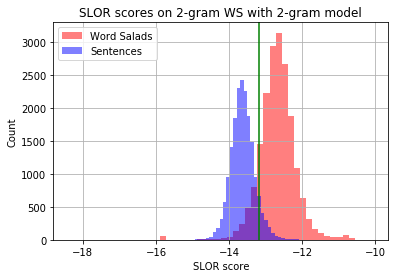

  2%|▏         | 1156/59757 [00:00<00:05, 11553.40it/s]

Training 3-gram language model


  3%|▎         | 1836/59757 [00:00<00:03, 18355.95it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:02<00:00, 22462.29it/s]


The scores on 3-grams are:
The model has accuracy 0.9377, with F-measure 0.9369 precision 0.9509 and recall 0.9233


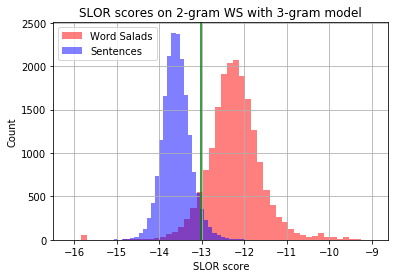

  1%|▏         | 883/59757 [00:00<00:06, 8820.57it/s]

Training 4-gram language model


  4%|▍         | 2392/59757 [00:00<00:04, 11956.18it/s]

Training 3-gram language model


  3%|▎         | 1722/59757 [00:00<00:03, 17211.03it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:03<00:00, 18838.56it/s]


The scores on 4-grams are:
The model has accuracy 0.9435, with F-measure 0.9424 precision 0.9629 and recall 0.9227


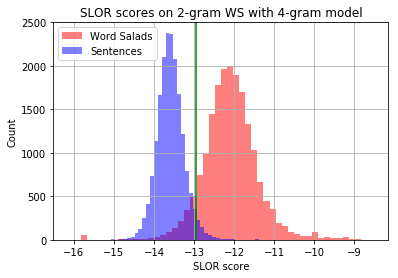

  1%|▏         | 786/59757 [00:00<00:07, 7854.18it/s]

Training 5-gram language model


  2%|▏         | 955/59757 [00:00<00:06, 9538.57it/s]

Training 4-gram language model


  2%|▏         | 1129/59757 [00:00<00:05, 11287.51it/s]

Training 3-gram language model


  6%|▋         | 3855/59757 [00:00<00:02, 19265.07it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:02<00:00, 20761.67it/s]


The scores on 5-grams are:
The model has accuracy 0.9441, with F-measure 0.9432 precision 0.9611 and recall 0.9259


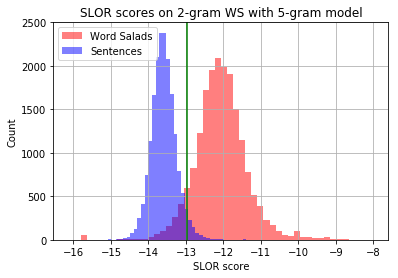

  1%|▏         | 787/59757 [00:00<00:07, 7863.24it/s]

Training 6-gram language model


  1%|▏         | 880/59757 [00:00<00:06, 8796.55it/s]

Training 5-gram language model


  1%|▏         | 857/59757 [00:00<00:06, 8554.83it/s]

Training 4-gram language model


  2%|▏         | 1107/59757 [00:00<00:05, 11057.28it/s]

Training 3-gram language model


  3%|▎         | 1777/59757 [00:00<00:03, 17764.68it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:02<00:00, 20400.92it/s]


The scores on 6-grams are:
The model has accuracy 0.9442, with F-measure 0.9433 precision 0.9611 and recall 0.9261


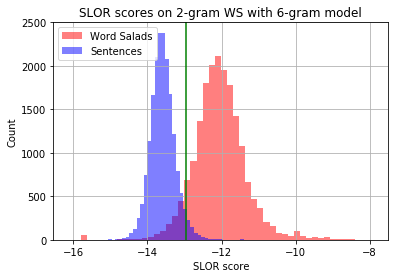

In [7]:
models = []
for n in range(2,7):
    models.append(train_and_test_lau(n,training_gram,training_ws,testing_gram,testing_ws,noise_order))

In [ ]:
## baseline_bi = Lau_classif(2)
baseline_tri = Lau_classif(3)
baseline_quad = Lau_classif(4)
baseline_pent = Lau_classif(5)
baseline_hex = Lau_classif(6)

baseline_bi.train_full_LM(training_gram)
baseline_tri.train_full_LM(training_gram)
baseline_quad.train_full_LM(training_gram)
baseline_pent.train_full_LM(training_gram)
baseline_hex.train_full_LM(training_gram)

baseline_bi.plot_scores( training_gram, training_ws,"training")
baseline_tri.plot_scores( training_gram, training_ws,"training")
baseline_quad.plot_scores( training_gram, training_ws,"training")
baseline_pent.plot_scores( training_gram, training_ws,"training")
baseline_hex.plot_scores( training_gram, training_ws,"training")

baseline_bi.plot_scores( testing_gram, testing_ws,"testing")
baseline_tri.plot_scores( testing_gram, testing_ws,"testing")
baseline_quad.plot_scores( testing_gram, testing_ws,"testing")
baseline_pent.plot_scores( testing_gram, testing_ws,"testing")
baseline_hex.plot_scores( testing_gram, testing_ws,"testing")


  2%|▏         | 979/59757 [00:00<00:06, 9786.16it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:03<00:00, 19866.68it/s]


The scores on 2-grams are:
The model has accuracy 0.77, with F-measure 0.7496 precision 0.697 and recall 0.8108


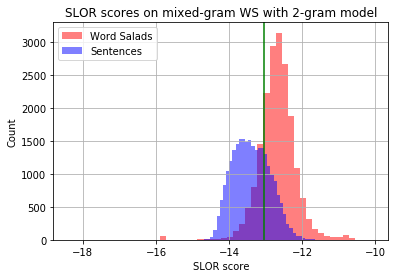

  2%|▏         | 1171/59757 [00:00<00:05, 11704.49it/s]

Training 3-gram language model


  2%|▏         | 1345/59757 [00:00<00:04, 13432.72it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:03<00:00, 15813.98it/s]


The scores on 3-grams are:
The model has accuracy 0.7853, with F-measure 0.7648 precision 0.715 and recall 0.8221


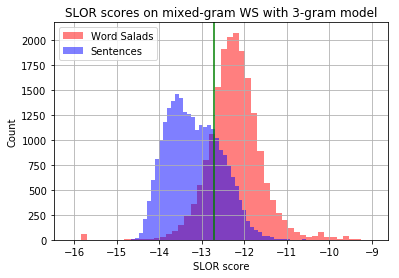

  1%|▏         | 888/59757 [00:00<00:06, 8863.50it/s]

Training 4-gram language model


  2%|▏         | 1101/59757 [00:00<00:05, 10994.39it/s]

Training 3-gram language model


  3%|▎         | 1528/59757 [00:00<00:03, 15263.67it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:02<00:00, 20778.15it/s]


The scores on 4-grams are:
The model has accuracy 0.7877, with F-measure 0.7707 precision 0.7118 and recall 0.8402


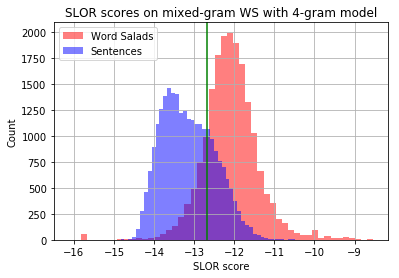

  1%|▏         | 805/59757 [00:00<00:07, 8047.51it/s]

Training 5-gram language model


  2%|▏         | 904/59757 [00:00<00:06, 9034.37it/s]

Training 4-gram language model


  4%|▎         | 2237/59757 [00:00<00:05, 11180.36it/s]

Training 3-gram language model


  3%|▎         | 1969/59757 [00:00<00:02, 19676.18it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:03<00:00, 18246.27it/s]


The scores on 5-grams are:
The model has accuracy 0.7881, with F-measure 0.772 precision 0.7105 and recall 0.8452


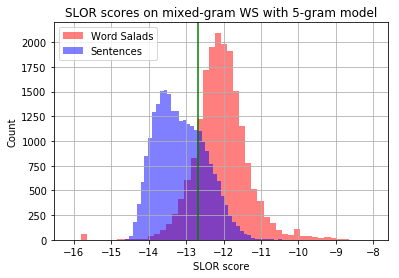

  1%|▏         | 829/59757 [00:00<00:07, 8278.40it/s]

Training 6-gram language model


  1%|          | 676/59757 [00:00<00:08, 6756.24it/s]

Training 5-gram language model


  1%|▏         | 859/59757 [00:00<00:06, 8584.36it/s]

Training 4-gram language model


  2%|▏         | 1070/59757 [00:00<00:05, 10646.65it/s]

Training 3-gram language model


  3%|▎         | 1622/59757 [00:00<00:03, 16216.27it/s]

Training 2-gram language model


100%|██████████| 59757/59757 [00:03<00:00, 18287.66it/s]


The scores on 6-grams are:
The model has accuracy 0.7929, with F-measure 0.7703 precision 0.7278 and recall 0.8182


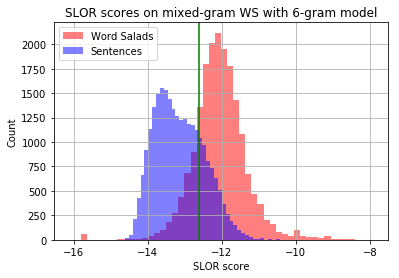

In [10]:
labeled_gram,labeled_ws = exp.load_corpora_from_file("Data/hundo_gram","Data/euro.hundo2-mix")
datasplit = int(math.floor(0.8*len(labeled_gram)))
training_gram = [sent for sent,label in labeled_gram[:datasplit]]
testing_gram = [sent for sent,label in labeled_gram[datasplit:]]

training_ws = [sent for sent,label in labeled_ws[:datasplit]]
testing_ws = [sent for sent,label in labeled_ws[datasplit:]]

models_mix = []
for n in range(2,7):
    models.append(train_and_test_lau(n,training_gram,training_ws,testing_gram,testing_ws,"mixed"))
